<a href="https://colab.research.google.com/github/adasegroup/ML2020_seminars/blob/master/seminar15/seminar_anomaly_detection_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plan
    
* basic examples of anomaly detection with sklearn methods
 * Robust covariance
 * One-class SVM
 * Isolation Forest (and its extended version)
 * Local Outlier Factor
 * PCA-based Anomaly Detector
 * Anomaly detection as classification problem
 * https://scikit-learn.org/stable/modules/outlier_detection.html
 
* practice & competition https://www.kaggle.com/t/934cc8d07dd649acb9ab40a3386a59d3 - invite link to accept rules (www.kaggle.com/c/ml2020anomalies)
 * password for archives skml20200309
 * train: https://drive.google.com/file/d/1YSE7dkM5nVl4BJ3dQOFHW_cKKSP-FRIm/view?usp=sharing
 * test: https://drive.google.com/file/d/1QqqjvE6Ny_AvqZcIhxuXipm_2NZhDpq0/view?usp=sharing
 * sample: https://drive.google.com/file/d/1MAXh4c0pX1mrcNoUCly8nqFuWbyToTR5/view?usp=sharing

## Unsupervised Anomaly Detection

It's really hard to define anomalies properly. The intuition behind this problem is to find objects that are unexpected in the test data given train sample.

One of the approaches is the following:

Suppose we have some mechanism of generating data. All data wich came from another mechanism is abnormal.

Example:
 * Normal data from N(0, 1)
 * Anomaly data from N(0, 10)
 
Note that for some points it almost impossible to destinguish normal and abnormal.
 
Usually we assume that amount of anomaly data is less than normal.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
%matplotlib inline

## General Framework for Unsupervised Anomaly Detection

* Define what is normal.
* Calculate deviation from normal.

In [2]:
def plot_level_lines(model, data, size=100, make_new_figure=True, scatter=True):
    if make_new_figure:
        plt.figure(figsize=(9, 6))
    x_min = data[:, 0].min() - 0.1
    x_max = data[:, 0].max() + 0.1
    y_min = data[:, 1].min() - 0.1
    y_max = data[:, 1].max() + 0.1
    all_x = np.linspace(x_min, x_max, size)
    all_y = np.linspace(y_min, y_max, size)
    XX, YY = np.meshgrid(all_x, all_y)
    test_data = np.c_[XX.ravel(), YY.ravel()]
    try:
        predictions = model.decision_function(test_data).reshape((size, size))
        data_scores = model.predict(data)
        anomaly_scores = model.decision_function(data)
    except AttributeError:
        predictions = model._decision_function(test_data).reshape((size, size))
        data_scores = model._predict(data)
        anomaly_scores = model._decision_function(data)
        
    plt.contourf(all_x, all_y, predictions)
    plt.colorbar()
    
    threshold = anomaly_scores[data_scores==1.0].min()
    plt.contour(XX, YY, predictions, levels=[threshold], linewidths=2, colors='k')

    if scatter:
        plt.scatter(data[:, 0], data[:, 1], color='k', alpha=0.7)
    axes = plt.gca()
    axes.set_xlim([x_min,x_max])
    axes.set_ylim([y_min,y_max])

In [3]:
def unimodal_data_generator(size=100, anomaly_fraction=0.1):
    dim_count = 2
    anomaly_size = int(size * anomaly_fraction)
    normal_size = size - anomaly_size

    linear_transformation = np.array([[2, 0.5],
                                      [0.5, 1.5]])
    normal_data = np.random.randn(normal_size, dim_count) @ linear_transformation
    anomaly_data = np.random.randn(anomaly_size, dim_count)*5
    x_min = normal_data[:, 0].min()
    x_max = normal_data[:, 0].max()
    y_min = normal_data[:, 1].min()
    y_max = normal_data[:, 1].max()
    data = np.concatenate([normal_data, anomaly_data], axis=0)
    return data

## Robust Covariance

Assumes the data is Gaussian and learns an ellipse. Idea: find an ellipsoid of minimal volume with a constraint, namely, that the ellipsoid must contain h points inside its boundary.

Pros:
* Easy to use
* Interpretable
* Robust to outliers


Cons:
* Suitable only for unimodal distribution
* Can suffer from ill-posed covariance matrix
* May break or not perform well in high-dimensional (when n_samples < n_features ** 2)

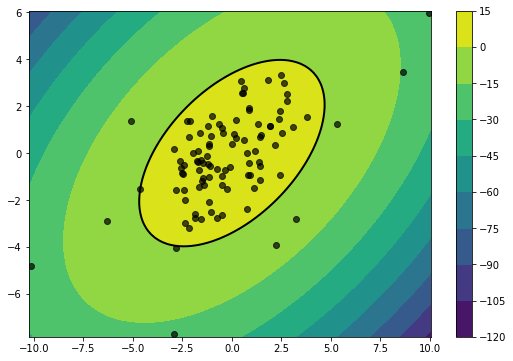

In [4]:
from sklearn.covariance import EllipticEnvelope
np.random.seed(3)
data = unimodal_data_generator()

model = EllipticEnvelope(assume_centered=True, # Data centering
                         contamination=0.1) # Anomalies fraction
model.fit(data)
plot_level_lines(model, data)

## One Class SVM

Try to separate data points from coordinate origin.

Pros:
* No parametric assumptions
* Applicable even for objects not from $R^n$ (because of kernel trick)

Cons:
* Computationaly difficult
* Have to store part of the train data
* Sensitive to outliers, thus the training set should not be contaminated by outliers.

In [5]:
def data_generation(size=100, anomaly_fraction=0.1):
    """Вспомогательная функция для генерации данных"""
    dim_count = 2
    anomaly_size = int(size * anomaly_fraction)
    normal_size = size - anomaly_size
    normal_data = make_blobs(normal_size)[0]
    anomaly_data = np.random.rand(anomaly_size, dim_count)
    x_min = normal_data[:, 0].min()
    x_max = normal_data[:, 0].max()
    y_min = normal_data[:, 1].min()
    y_max = normal_data[:, 1].max()
    anomaly_data[:, 0] *= x_max - x_min
    anomaly_data[:, 1] *= y_max - y_min
    anomaly_data[:, 0] += x_min
    anomaly_data[:, 1] += y_min
    data = np.concatenate([normal_data, anomaly_data], axis=0)
    return data

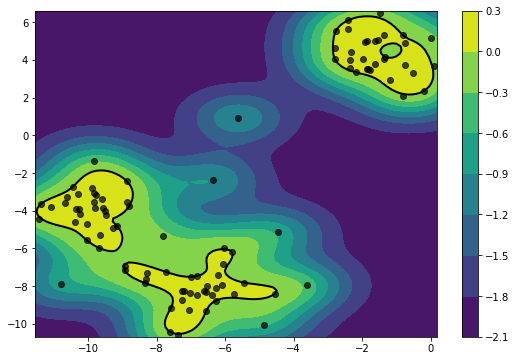

In [6]:
from sklearn.svm import OneClassSVM

np.random.seed(1)
data = data_generation()

model = OneClassSVM(nu=0.3, # Anomalies Fraction
                    kernel='rbf', # Kenrel function
                    gamma=0.5) # Kernel width
model.fit(data)

plot_level_lines(model, data)

# Isolation Forest

Idea: Let's build a tree which tries to isolate points from the training set. On each iteration we will make a random split. The more splits we need to isolate point, the less abnormal this point is.

Pros:

* Very robust technique

Cons:

* Non interpretable
* Cannot distinguish concentrated anomalies from normal points

![alt text](https://github.com/adasegroup/ML2020_seminars/raw/master/seminar15/img/isolforest.png "Isolation Forest")
https://arxiv.org/abs/1811.02141

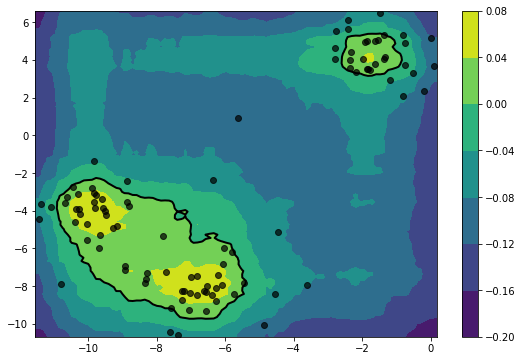

In [7]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100,
                        contamination=0.3, #check difference with 0.1
                        max_features=1.0,
                        max_samples=1.0,
                        bootstrap=True,
                        random_state=0)
model.fit(data)

plot_level_lines(model, data)

## Extended Isolation Forest

![alt text](https://github.com/adasegroup/ML2020_seminars/raw/master/seminar15/img/isolforest_ext.png "Extended Isolation Forest")
https://arxiv.org/abs/1811.02141

![alt text](https://github.com/adasegroup/ML2020_seminars/raw/master/seminar15/img/isolforest_cmp.png "Comparison of Isolation Forests")
https://arxiv.org/abs/1811.02141

# Local Outlier Factor

Idea: usually normal points are highly concentrated whereas bnormal points appear in low density areas.

Pros:
* No parametric assumptions

Cons:
* Suffers from the curse of dimensionality
* Cannot distinguish concentrated anomalies from normal points

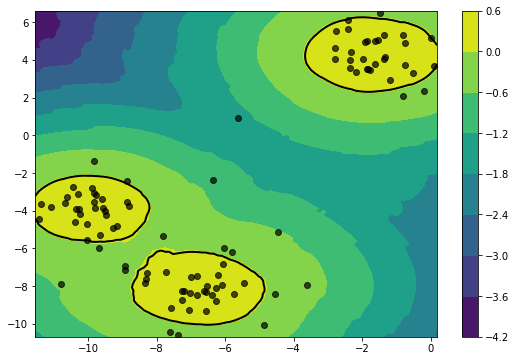

In [8]:
from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor(n_neighbors=20, 
                           contamination=0.2,
                           metric='minkowski', 
                           p=2,
                           novelty=True)
model.fit(data)

plot_level_lines(model, data)

# Summary & comparison

![alt text](https://github.com/adasegroup/ML2020_seminars/raw/master/seminar15/img/sphx_glr_plot_anomaly_comparison_001.png "Comparison of basic methods")
https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py

# PCA-based anomaly detection

PCA finds projections that maximize explained variance in training data. Let's try to use these projections to find anomalies in test data.

![alt text](https://github.com/adasegroup/ML2020_seminars/raw/master/seminar15/img/pca_anomaly.png "PCA based anomaly detection")

Text(0,0.5,'y')

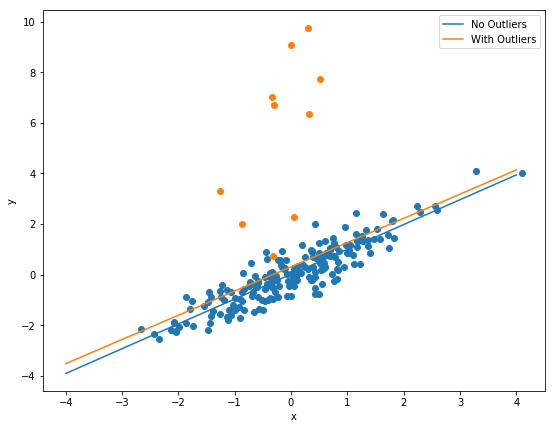

In [9]:
# Clean data
plt.figure(figsize=(9, 7))
np.random.seed(2)
X = np.random.randn(200)
Y = X + np.random.randn(len(X)) * 0.5
model = LinearRegression()
model.fit(X.reshape(-1, 1), Y)
test_x = np.linspace(-4, 4, 100)
predictions = model.predict(test_x.reshape(-1, 1))
plt.plot(X, Y, 'o')
plt.plot(test_x, predictions, label='No Outliers', color='C0')

# Add anomaly
sub_inds = np.random.choice(len(X), 10, replace=False)
XA = X.copy()
YA = Y.copy()
YA[sub_inds] = Y[sub_inds] + np.random.rand(len(sub_inds)) * 10
model.fit(XA.reshape(-1, 1), YA)
predictions = model.predict(test_x.reshape(-1, 1))
plt.plot(test_x, predictions, label='With Outliers')
plt.plot(XA[sub_inds], YA[sub_inds], 'o', color='C1')
plt.legend(loc='best')

plt.xlabel('x')
plt.ylabel('y')

In [10]:
# solution
from sklearn.base import BaseEstimator, OutlierMixin
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

class PCAAnomalyDetector(BaseEstimator, OutlierMixin):
    def __init__(self, n_components=2, contamination=0.1):
        self.n_components = n_components
        self.contamination = contamination
    
    def fit(self, X, y=None):
        self.pca_ = PCA(n_components=self.n_components)
        self.pca_.fit(X)

        scores = self.score_samples(X)
        self.offset_ = np.quantile(scores, self.contamination)
        return self
    
    def transform(self, X):
        projection = self.pca_.transform(X)
        return X - self.pca_.inverse_transform(projection)
        
    def score_samples(self, X):
        residuals = self.transform(X)
        return -np.log1p(np.linalg.norm(residuals, ord=2, axis=1))

    def decision_function(self, X):
        return self.score_samples(X) - self.offset_

    def predict(self, X):
        y = np.sign(self.decision_function(X))
        return np.asarray(y, dtype=np.intp)

In [11]:
detector = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCAAnomalyDetector(n_components=1, contamination=0.1))
])

In [12]:
train_data = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))

In [13]:
test_data = np.hstack((XA.reshape(-1, 1), YA.reshape(-1, 1)))

In [14]:
detector.fit(train_data)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca', PCAAnomalyDetector(contamination=0.1, n_components=1))],
         verbose=False)

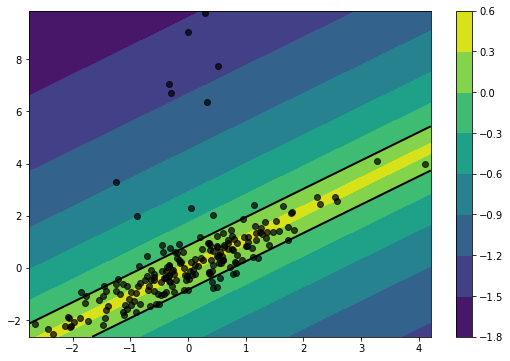

In [15]:
plot_level_lines(detector, test_data)

# Anomaly detection as classification problem

In [16]:
np.random.seed(3)
phi = 2
S = np.array([[1, 0], 
              [0, 0.3]])
C = np.array([[1, 0], [0, 1.5]])
A = S @ np.array([[np.cos(phi), -np.sin(phi)], 
                  [np.sin(phi), np.cos(phi)]])
b = np.array([3, 0])
e, r = np.array([1, 0]), 5
#e, r = np.array([-0.5, -0.5]), 10 # try
#e, r = np.array([-1, -4]), 1 # try

X = np.vstack((np.random.randn(3000, 2) @ C,
               np.random.randn(100, 2) @ A + b, 
               r*(np.random.rand(20, 2) + e)))
y = np.hstack((np.zeros(3000), np.ones(120)))

(-3.819654817783687, 10.237291090469641, -5.870694139564639, 6.104932475465478)

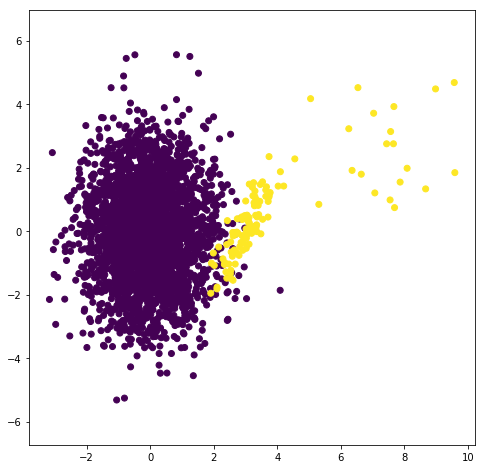

In [17]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')

In [18]:
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5)

In [19]:
from sklearn.linear_model import LogisticRegression
from collections import Counter

![alt text](sampling.png "Sampling techniques")
Undersampling and Oversampling

![alt text](smote.png "SMOTE")
Synthetic Minority Over-sampling Technique

In [20]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [21]:
sampler = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)

In [22]:
over_sampler = SMOTE(random_state=0)
X_oversampled, y_oversampled = over_sampler.fit_sample(X_train, y_train)

In [23]:
print('y_train counts:', Counter(y_train))
print('y_resampled counts:', Counter(y_resampled))
print('y_oversampled counts:', Counter(y_oversampled))

y_train counts: Counter({0.0: 1500, 1.0: 60})
y_resampled counts: Counter({0.0: 60, 1.0: 60})
y_oversampled counts: Counter({0.0: 1500, 1.0: 1500})


In [24]:
model_balanced = LogisticRegression(class_weight='balanced')
model = LogisticRegression()
model_resampled = LogisticRegression()
model_oversampled = LogisticRegression()

model_balanced.fit(X_train, y_train)
model.fit(X_train, y_train)
model_resampled.fit(X_resampled, y_resampled)
model_oversampled.fit(X_oversampled, y_oversampled)

predictions_balanced = model_balanced.predict_proba(X_test)[:, 1]
predictions = model.predict_proba(X_test)[:, 1]
predictions_resampled = model_resampled.predict_proba(X_test)[:, 1]
predictions_oversampled = model_oversampled.predict_proba(X_test)[:, 1]

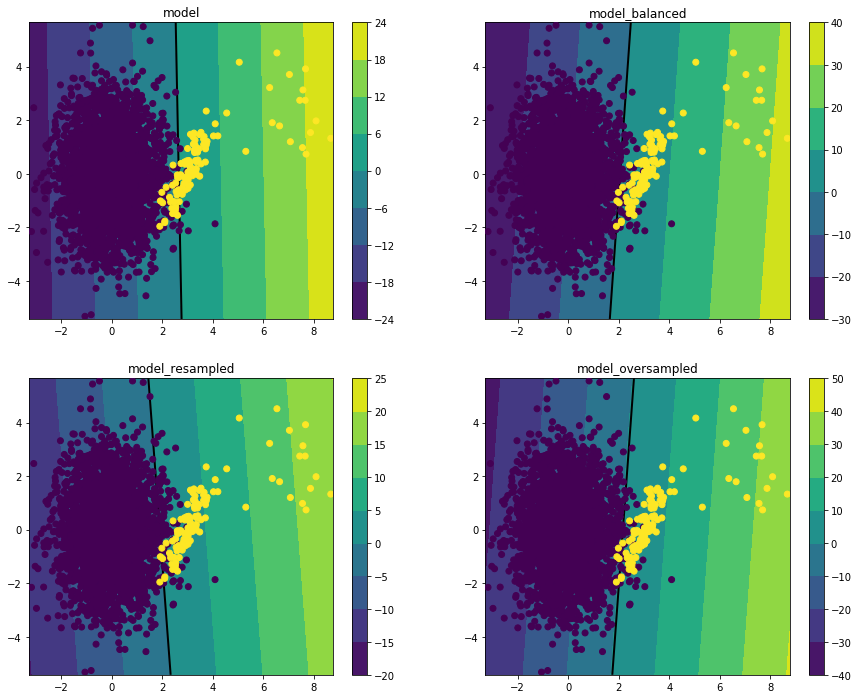

In [25]:
plt.figure(figsize=(15, 12))
models = ['model', 'model_balanced', 'model_resampled', 'model_oversampled']
for i in range(len(models)):
    plt.subplot(2, 2, i + 1)
    plot_level_lines(locals()[models[i]], X_test, make_new_figure=False, scatter=False)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10)
    plt.title(models[i])

In [26]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

(0, 1)

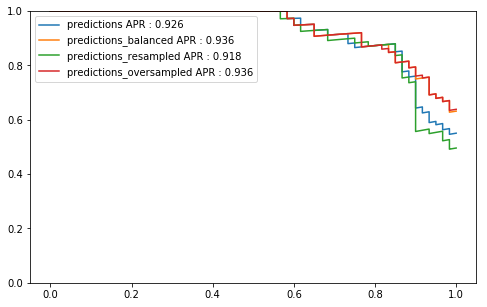

In [27]:
preds = ['predictions', 'predictions_balanced', 'predictions_resampled', 'predictions_oversampled']
plt.figure(figsize=(8, 5))

for i in range(len(preds)):
    precision, recall, _ = precision_recall_curve(y_test, locals()[preds[i]])
    plt.plot(recall, precision, label='{} APR : {:.3f}'.format(preds[i], average_precision_score(y_test, locals()[preds[i]])))
plt.legend()
plt.ylim([0, 1])